In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [3]:
from tensorflow.keras.utils import to_categorical

In [4]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

In [5]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']

cat_vars = ['Store', 'DayOfWeek']

In [6]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Precipitationmm',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool']
contin_vars = ['BeforeStateHoliday_bool', 'Max_TemperatureC']

In [7]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [8]:
uniques.T

,uniques
Store,1115
DayOfWeek,7


# Asignación de dimensión de embeddings

In [9]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 2, 'Year': 2, 'Month': 2,
'Day': 10, 'StateHoliday': 2, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 25, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_bool_fw': 1,
'StateHoliday_bool_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

In [10]:
for v in cat_vars:
    uniques_ = df[v].unique()
    uniques_.sort()
    print(v, cat_var_dict[v], len(uniques_), uniques_)
    print()

Store 50 1115 [   0    1    2 ... 1112 1113 1114]

DayOfWeek 2 7 [0 1 2 3 4 5 6]



# Definición de modelo

In [11]:
add_customers = True
log_output = False
output_activation = 'linear'

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2

In [13]:
def get_cat_vars_model(cat_vars, uniques, cat_var_dict):
    cat_vars_embed_outs = []
    cat_var_inputs = []
    for cat_var in cat_vars:
        cat_var_in = Input(shape=(1,), name=f"{cat_var}_input")
        cat_var_inputs.append(cat_var_in)
        embed_out = Embedding(uniques[cat_var][0], cat_var_dict[cat_var], name=f'{cat_var}_Embed')(cat_var_in)
        flatten_out = Flatten(name=f"{cat_var}_flat")(embed_out)
        cat_vars_embed_outs.append(flatten_out)
    return cat_var_inputs, cat_vars_embed_outs

def get_cont_vars_input(contin_vars, dense_layer=False):
    cont_vars_inputs = []
    cont_vars_outputs = []
    for cont_var in contin_vars:
        cont_var_in = Input(shape=(1,), name=f"{cont_var}_input")
        cont_vars_inputs.append(cont_var_in)
        if dense_layer:
            cont_var_out = Dense(1, name=f"{cont_var}_input", activation = 'linear')(cont_var_in)
            cont_vars_outputs.append(cont_var_out)
        else:
            cont_vars_outputs.append(cont_var_in)
    return cont_vars_inputs, cont_vars_outputs

In [14]:
cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_24240\543933484.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  embed_out = Embedding(uniques[cat_var][0], cat_var_dict[cat_var], name=f'{cat_var}_Embed')(cat_var_in)


In [15]:
# Descomentar para ver resultados
# cat_vars_embed_outs
# cat_var_inputs
# cont_vars_inputs
# cont_vars_outs

In [16]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import LeakyReLU


merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)


#optamos por 4 capas densas, arrancamos con 1024 nueronas y fuimos bajando la cantidad hasta la última capa. 
# Los resultados con mas neuronas nos daban peores resultados
#para cada capa hicimos batchnormalization y dropout
#empezamos aplicando relu, pero el leakyrelu nos dió mejor resultado.
#Hemos probado con capas de 2000 neuronas por ejemplo y los resultados fueron siempre peores.


x = Dense(units=1024, name='dense_0_layer')(merged)
x = BatchNormalization(name='batch_norm_0')(x)
x = LeakyReLU(alpha=0.2)(x) 
x = Dropout(0.3, name='dropout_0')(x)

x = Dense(units=512, name='dense_1_layer')(x)
x = BatchNormalization(name='batch_norm_1')(x)
x = LeakyReLU(alpha=0.2)(x)  
x = Dropout(0.3, name='dropout_1')(x)

x = Dense(units=256, name='dense_2_layer')(x)
x = BatchNormalization(name='batch_norm_2')(x)
x = LeakyReLU(alpha=0.2)(x)  
x = Dropout(0.3, name='dropout_2')(x)

x = Dense(units=128, name='dense_3_layer')(x)
x = BatchNormalization(name='batch_norm_3')(x)
x = LeakyReLU(alpha=0.2)(x)  
x = Dropout(0.3, name='dropout_3')(x)

# Salidas
output_1 = Dense(1, name='Sales', activation=output_activation)(x)
output_2 = Dense(1, name='Customers', activation=output_activation)(x)



c:\Users\Usuario\OneDrive\Escritorio\holaaa-main (1) - copia\my_env\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [17]:
if add_customers:
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1, output_2])
else: 
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1])

In [18]:
# Descomentar para ver
#model.summary()

In [19]:
model.save_weights('initial.weights.h5')

In [20]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


In [21]:
from matplotlib import pyplot as plt
# plt.figure(figsize=(20,5))
# plt.plot((df_train[df_train['Store']==1]['Sales'].values - df_train[df_train['Store']==1]['Sales'].mean())/df_train[df_train['Store']==1]['Sales'].std())
# plt.show()
# plt.figure(figsize=(20,5))
# plt.plot(np.log(df_train[df_train['Store']==1]['Sales'].values)/np.max(np.log(df_train[df_train['Store']==1]['Sales'].values)))
# plt.show()

In [22]:
stores_mean = {}
for store, g_df in df_train.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [23]:
df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)

df_train.loc[:, 'Sales_store'] = df_train['Sales'] - df_train['mean_by_store']
df_val.loc[:, 'Sales_store'] = df_val['Sales'] - df_val['mean_by_store']

C:\Users\Usuario\AppData\Local\Temp\ipykernel_24240\3553976367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24240\3553976367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24240\3553976367.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [24]:
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping as EarlyStopping

In [25]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

In [26]:
def get_metric(df, sales_):
    return np.sqrt((((df['Sales'] - sales_)/df['Sales'])**2).mean())

In [27]:
get_metric(df_val, df_val['mean_by_store'])

np.float64(0.3071746085338871)

In [28]:
all_vars = cat_vars + contin_vars
X_train = np.hsplit(df_train[all_vars].values, len(all_vars))
X_val = np.hsplit(df_val[all_vars].values, len(all_vars))
X_test = np.hsplit(df_test[all_vars].values, len(all_vars))

In [29]:
if add_customers:
    y_out_columns = ['Sales', 'Customers']
else:
    y_out_columns = ['Sales_store']
    
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
    y_mean = df_train[y_out_columns].mean().values
    y_std = df_train[y_out_columns].std().values
    y_train = (df_train[y_out_columns].values - y_mean)/y_std
    y_val = (df_val[y_out_columns].values - y_mean)/y_std
   # y_max = df_train[y_out_columns].max().values
    #y_train = df_train[y_out_columns].values/y_max
    #y_val = df_val[y_out_columns].values/y_max
y_train = np.hsplit(y_train, y_train.shape[1])
y_val = np.hsplit(y_val, y_val.shape[1])

In [30]:


from tensorflow.keras.optimizers import RMSprop

lr = 0.001  
optimizer = RMSprop(learning_rate=lr, rho=0.9) #intentamos con un Adam pero los resultados con RMS nos dieron mejor.
# el RMSprop nos sirve para cuando hay datos que son muy variados.
model.compile(optimizer=optimizer, metrics=['mse', rmspe], loss='mse')


In [31]:
if add_customers:
    checkpoint = ModelCheckpoint('bestmodel.keras', monitor='val_Sales_mse', verbose=1, save_best_only=True)
else:
    checkpoint = ModelCheckpoint('bestmodel.keras', monitor='val_loss', verbose=1, save_best_only=True)

In [32]:


#utilizamos dos callback. Ambos nos sirven para mejorar la eficiencia y el rendimiento del entrenamiento del modelo. Al implementarlos nos dieron mejores resultados.

lr_scheduler= ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose = 1,
    min_1r= 1e-6
)

es=EarlyStopping(
    monitor='val_Sales_rmspe',
    patience=20,
    verbose=1,
    restore_best_weights = True,
    mode = 'min'
)


In [33]:
epochs = 20
batch_size = 256
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=epochs, batch_size=batch_size, callbacks=[checkpoint, lr_scheduler,es], verbose=2)

Epoch 1/20


c:\Users\Usuario\OneDrive\Escritorio\holaaa-main (1) - copia\my_env\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Store_input', 'DayOfWeek_input', 'BeforeStateHoliday_bool_input', 'Max_TemperatureC_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(



Epoch 1: val_Sales_mse improved from inf to 0.23666, saving model to bestmodel.keras
3181/3181 - 59s - 18ms/step - Customers_loss: 0.2098 - Customers_rmspe: 16.0314 - Sales_loss: 0.3842 - Sales_mse: 0.3842 - loss: 0.5940 - val_Customers_loss: 0.0928 - val_Customers_rmspe: 14.5621 - val_Sales_loss: 0.2367 - val_Sales_mse: 0.2367 - val_loss: 0.3295 - learning_rate: 1.0000e-03
Epoch 2/20


c:\Users\Usuario\OneDrive\Escritorio\holaaa-main (1) - copia\my_env\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_Sales_rmspe` which is not available. Available metrics are: Customers_loss,Customers_rmspe,Sales_loss,Sales_mse,loss,val_Customers_loss,val_Customers_rmspe,val_Sales_loss,val_Sales_mse,val_loss,learning_rate
  current = self.get_monitor_value(logs)



Epoch 2: val_Sales_mse improved from 0.23666 to 0.23316, saving model to bestmodel.keras
3181/3181 - 49s - 15ms/step - Customers_loss: 0.1405 - Customers_rmspe: 13.9967 - Sales_loss: 0.3144 - Sales_mse: 0.3144 - loss: 0.4549 - val_Customers_loss: 0.0873 - val_Customers_rmspe: 13.0549 - val_Sales_loss: 0.2332 - val_Sales_mse: 0.2332 - val_loss: 0.3205 - learning_rate: 1.0000e-03
Epoch 3/20

Epoch 3: val_Sales_mse did not improve from 0.23316
3181/3181 - 48s - 15ms/step - Customers_loss: 0.1325 - Customers_rmspe: 13.5259 - Sales_loss: 0.3067 - Sales_mse: 0.3066 - loss: 0.4391 - val_Customers_loss: 0.1167 - val_Customers_rmspe: 14.9321 - val_Sales_loss: 0.2383 - val_Sales_mse: 0.2383 - val_loss: 0.3550 - learning_rate: 1.0000e-03
Epoch 4/20

Epoch 4: val_Sales_mse improved from 0.23316 to 0.22541, saving model to bestmodel.keras
3181/3181 - 49s - 15ms/step - Customers_loss: 0.1277 - Customers_rmspe: 13.5262 - Sales_loss: 0.3009 - Sales_mse: 0.3009 - loss: 0.4286 - val_Customers_loss: 0.0

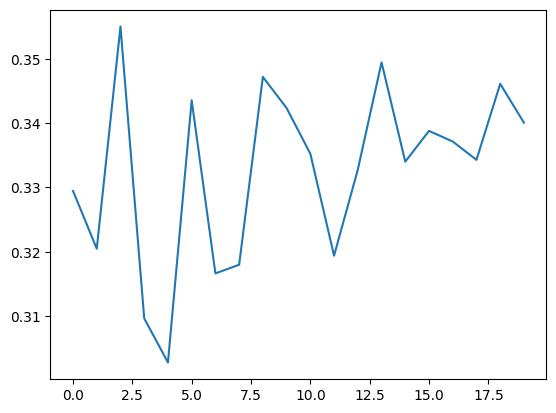

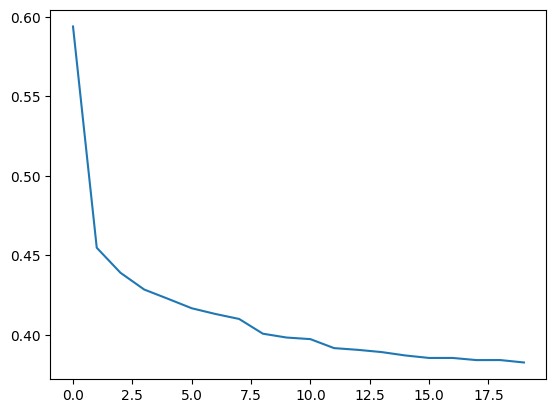

In [34]:
plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_Customers_mse'])
# plt.plot(history.history['val_Sales_mse'])
plt.show()
plt.plot(history.history['loss'])
# plt.plot(history.history['Customers_mse'])
# plt.plot(history.history['Sales_mse'])

# Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [35]:
model.evaluate(X_val, y_val)

944/944 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Customers_loss: 0.0935 - Customers_rmspe: 8.4559 - Sales_loss: 0.2658 - Sales_mse: 0.2658 - loss: 0.3593


[0.34006673097610474,
 0.24614349007606506,
 0.09404167532920837,
 7.36840295791626,
 0.2460603564977646]

In [36]:
model.load_weights('bestmodel.keras')
model.evaluate(X_val, y_val)

944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - Customers_loss: 0.0830 - Customers_rmspe: 7.2082 - Sales_loss: 0.2704 - Sales_mse: 0.2704 - loss: 0.3533


[0.302794486284256,
 0.22336333990097046,
 0.07967226952314377,
 6.239414215087891,
 0.2231815755367279]

In [37]:
# model.load_weights('bestmodel.hdf5')
# model.evaluate(X_val, y_val)
# 30188/30188 [==============================] - 5s 172us/step
# [0.12197033089921382,
#  0.07211007360268763,
#  0.037183713050426136,
#  0.07211007360268763,
#  0.037183713050426136]

# [0.12932546436786652,
#  0.07751645147800446,
#  0.039259567856788635,
#  0.07751645147800446,
#  0.039259567856788635]

In [38]:
if log_output:
    if add_customers:
        y_pred = np.exp(model.predict(X_val, verbose=1)[0][:, 0]*max_log_y[0])
        y_pred_test = np.exp(model.predict(X_test, verbose=1)[0][:, 0]*max_log_y[0])
    else:
        y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)[:,0]
        y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)[:,0]
else:
    if add_customers:
        y_pred = (model.predict(X_val, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
        y_pred_test = (model.predict(X_test, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
    else:
#         y_pred = model.predict(X_val, verbose=1)[:,0]*y_std + y_mean
#         y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_std + y_mean
        y_pred = model.predict(X_val, verbose=1)[:,0]*y_max
        y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_max
y_pred_test[df_test['Open'] == 0] = 0

944/944 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1284/1284 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


In [39]:
np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred))

np.float64(0.22922146754883851)

In [40]:
y_pred_test[:10]

array([5300.41569705, 7672.00260839, 8619.01944123, 6480.81223177,
       7290.39620485, 6011.37561415, 7963.32540344, 7707.40008917,
       4961.96181582, 6230.35339393])

# Baseline

In [41]:
import pandas as pd
sample_csv = pd.read_csv('rossmann/rossmann/sample_submission.csv')



In [42]:
stores_mean = {}
for store, g_df in df.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [43]:
df_test['Sales'] = df_test['Store'].apply(stores_mean.get)
df_test.loc[df_test['Open'] == 0, 'Sales'] = 0

In [44]:
df_test[['Store', 'Sales']].head(10)

,Store,Sales
0,0,4759.096031
1,2,6942.568678
2,6,8817.050891
3,7,5539.358418
4,8,6562.337612
5,9,5568.420918
6,10,8030.977041
7,11,7589.598214
8,12,5034.747182
9,13,5508.567394


In [45]:
df_test[df_test['Open'] == 0][['Store', 'Sales']].head()

,Store,Sales
543,702,0.0
676,878,0.0
840,1096,0.0
1399,702,0.0
1532,878,0.0


In [46]:
sample_csv['Sales'] = df_test['Sales']

In [47]:
sample_csv.to_csv(f'submision_baseline.csv', index=False)

In [48]:
sample_csv.head()

,Id,Sales
0,1,4759.096031
1,2,6942.568678
2,3,8817.050891
3,4,5539.358418
4,5,6562.337612


# Sumbit a la competición

In [51]:

sample_csv = pd.read_csv('rossmann/rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submision_{add_customers}-{log_output}-{output_activation}--{epochs}-{batch_size}-{lr}.csv', index=False)


# Analisis de embedings

In [52]:
def plot_embed(layer_name, cat_names):
    Y = model.get_layer(layer_name).get_weights()[0]
    print(Y.shape)
    plt.figure(figsize=(8,8))
    plt.scatter(-Y[:, 0], -Y[:, 1])
    for i, txt in enumerate(cat_names):
        plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

(7, 2)


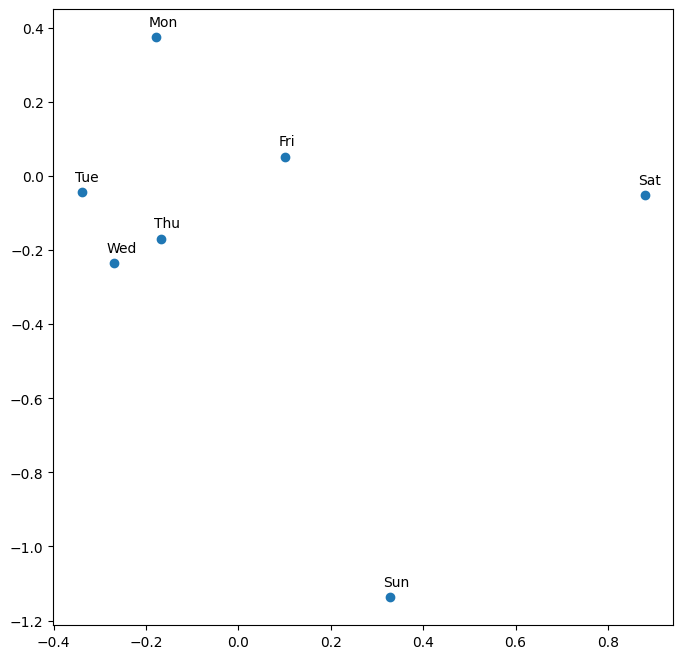

In [53]:
model.load_weights('bestmodel.keras')
plot_embed('DayOfWeek_Embed', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'])

In [ ]:
#plot_embed('Month_Embed', list(range(12)))

In [ ]:
#from sklearn.manifold import TSNE
#from sklearn.decomposition import PCA

In [ ]:
#day_of_week_embedding.shape



In [ ]:
#tsne = TSNE(n_components=2, random_state=1, learning_rate=10, n_iter=10000)
#Y = tsne.fit_transform(day_of_week_embedding)
#names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
#plt.figure(figsize=(8,8))
#plt.scatter(-Y[:, 0], -Y[:, 1])
#for i, txt in enumerate(names):
#    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

In [54]:
cat_vars

['Store', 'DayOfWeek']

## Store embeddings

In [55]:
submodel = Model(cat_var_inputs + cont_vars_inputs, merged)

In [56]:
submodel.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Store_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DayOfWeek_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Store_Embed         │ (None, 1, 50)     │     55,750 │ Store_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DayOfWeek_Embed     │ (None, 1, 2)      │         14 │ DayOfWeek_input[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Store_flat          │ (None, 50)        │          0 │ Store_Embed[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DayOfWeek_flat      │ (None, 2)         │          0 │ DayOfWeek_Embed[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BeforeStateHoliday… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Max_TemperatureC_i… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ All_Concatenate     │ (None, 54)        │          0 │ Store_flat[0][0], │
│ (Concatenate)       │                   │            │ DayOfWeek_flat[0… │
│                     │                   │            │ BeforeStateHolid… │
│                     │                   │            │ Max_TemperatureC… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,764 (217.83 KB)

 Trainable params: 55,764 (217.83 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
submodel.save('embeddings_model.hdf5')